**Import required modules**

In [1]:
! pip install opencv-python
! pip install opencv-contrib-python

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


**Data Pre-Processing**

*Read the data and storing it into DataFrame*

In [3]:
# Generate data paths with labels
data_dir = "D:/Mini Project/chest_xray/train"
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
df

,filepaths,labels
0,D:/Mini Project/chest_xray/train\NORMAL\IM-011...,NORMAL
1,D:/Mini Project/chest_xray/train\NORMAL\IM-011...,NORMAL
2,D:/Mini Project/chest_xray/train\NORMAL\IM-011...,NORMAL
3,D:/Mini Project/chest_xray/train\NORMAL\IM-012...,NORMAL
4,D:/Mini Project/chest_xray/train\NORMAL\IM-012...,NORMAL
...,...,...
5211,D:/Mini Project/chest_xray/train\PNEUMONIA\per...,PNEUMONIA
5212,D:/Mini Project/chest_xray/train\PNEUMONIA\per...,PNEUMONIA
5213,D:/Mini Project/chest_xray/train\PNEUMONIA\per...,PNEUMONIA
5214,D:/Mini Project/chest_xray/train\PNEUMONIA\per...,PNEUMONIA


*Split the dataframe in test, train, valid*

In [5]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

**Create Image Generator**

In [6]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 626 validated image filenames belonging to 2 classes.
Found 418 validated image filenames belonging to 2 classes.


*Samples from train data*

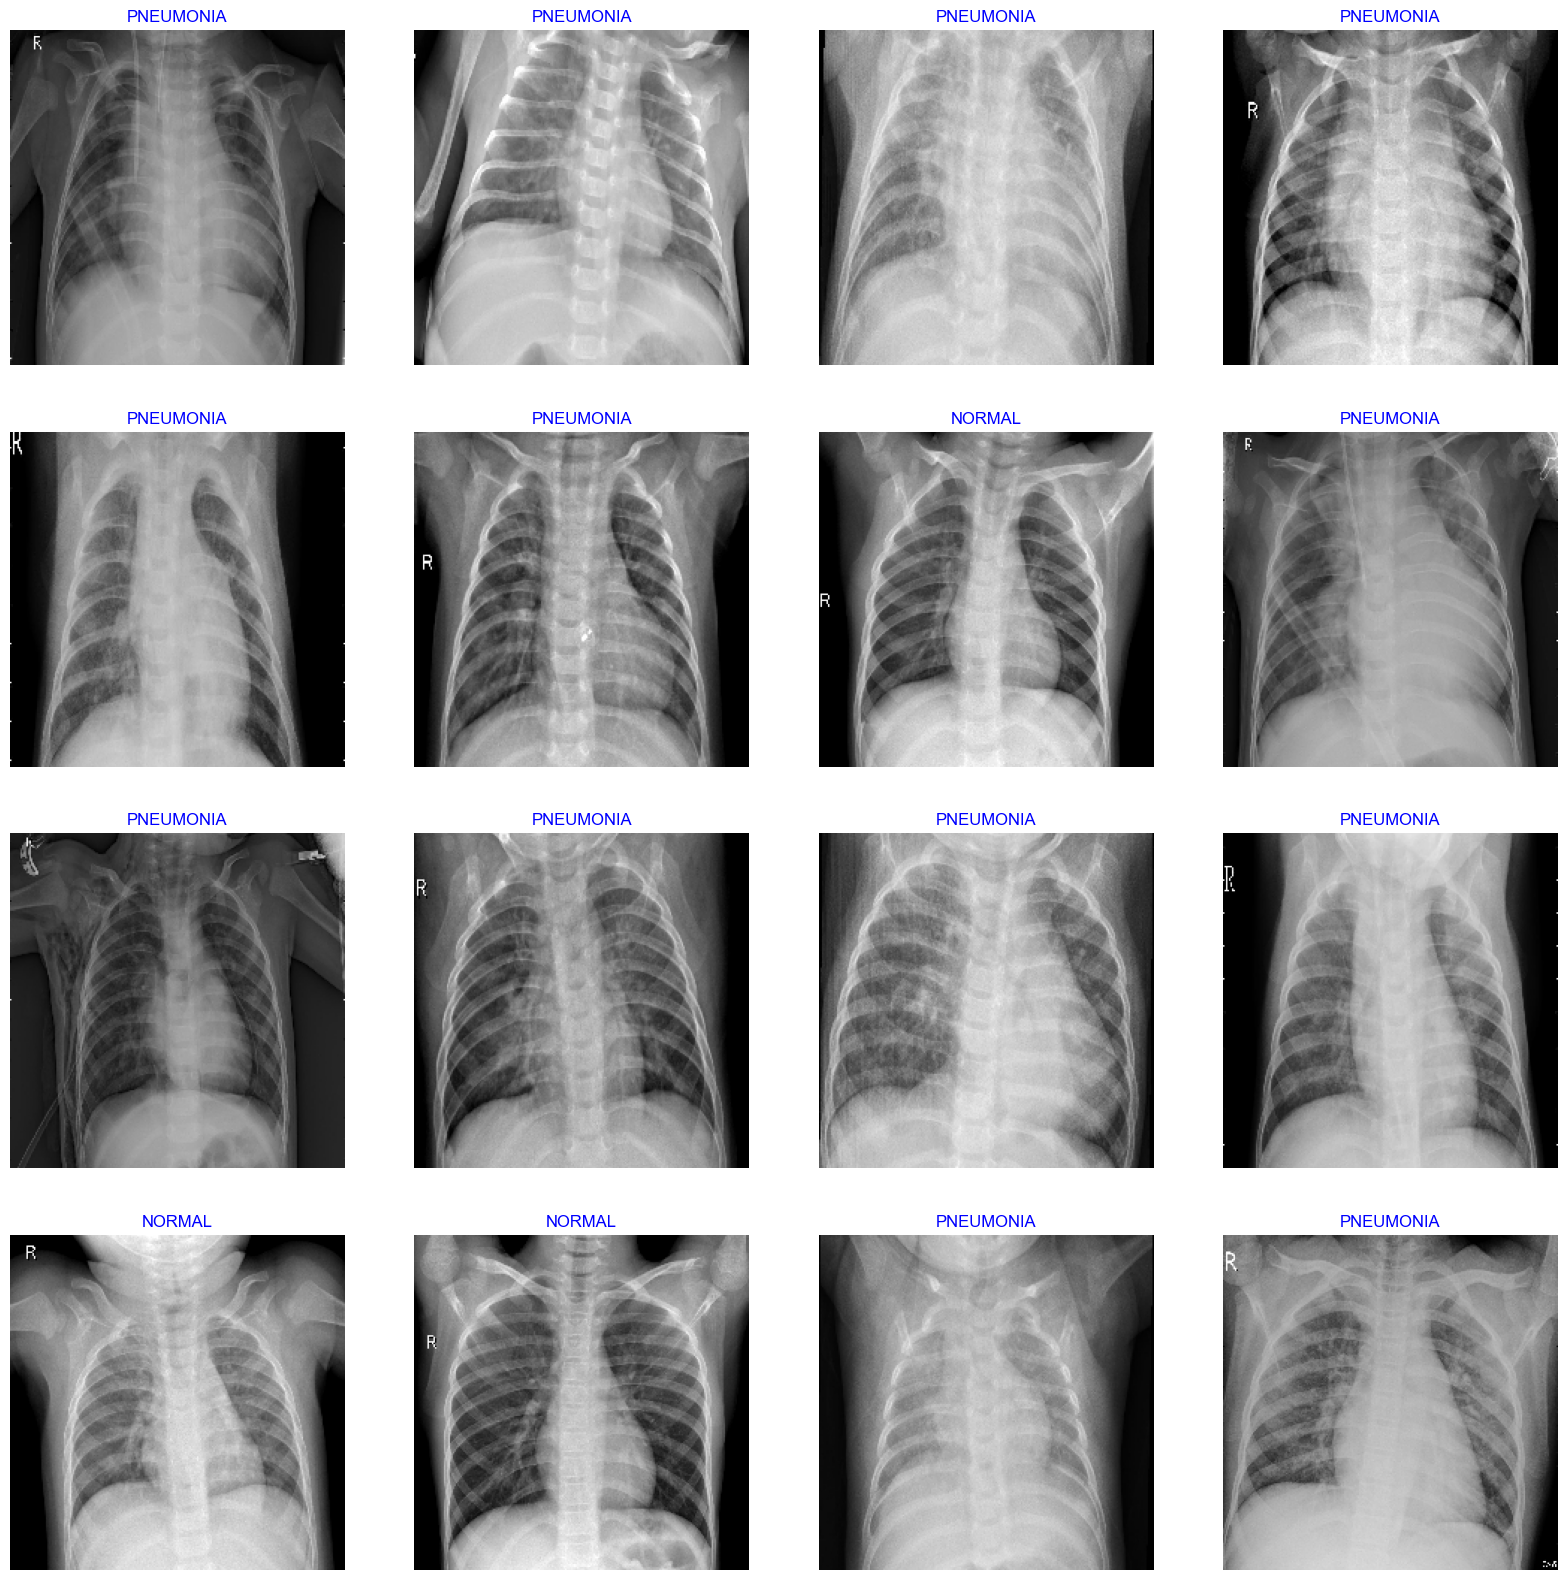

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')

**Model Structure**

*Generic Model Creation*

In [8]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 4383141 (16.72 MB)
Trainable params: 33101

**Model Training**

In [9]:
batch_size = 16   # set batch size for training
epochs = 5   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/5
261/261 [==============================] - 254s 932ms/step - loss: 5.1563 - accuracy: 0.8993 - val_loss: 3.3897 - val_accuracy: 0.9665
Epoch 2/5
261/261 [==============================] - 267s 1s/step - loss: 2.6628 - accuracy: 0.9446 - val_loss: 1.9646 - val_accuracy: 0.9696
Epoch 3/5
261/261 [==============================] - 287s 1s/step - loss: 1.5825 - accuracy: 0.9597 - val_loss: 1.2004 - val_accuracy: 0.9808
Epoch 4/5
261/261 [==============================] - 279s 1s/step - loss: 1.0079 - accuracy: 0.9588 - val_loss: 0.8018 - val_accuracy: 0.9649
Epoch 5/5
261/261 [==============================] - 293s 1s/step - loss: 0.6964 - accuracy: 0.9628 - val_loss: 0.5597 - val_accuracy: 0.9728


*Model Performance*

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

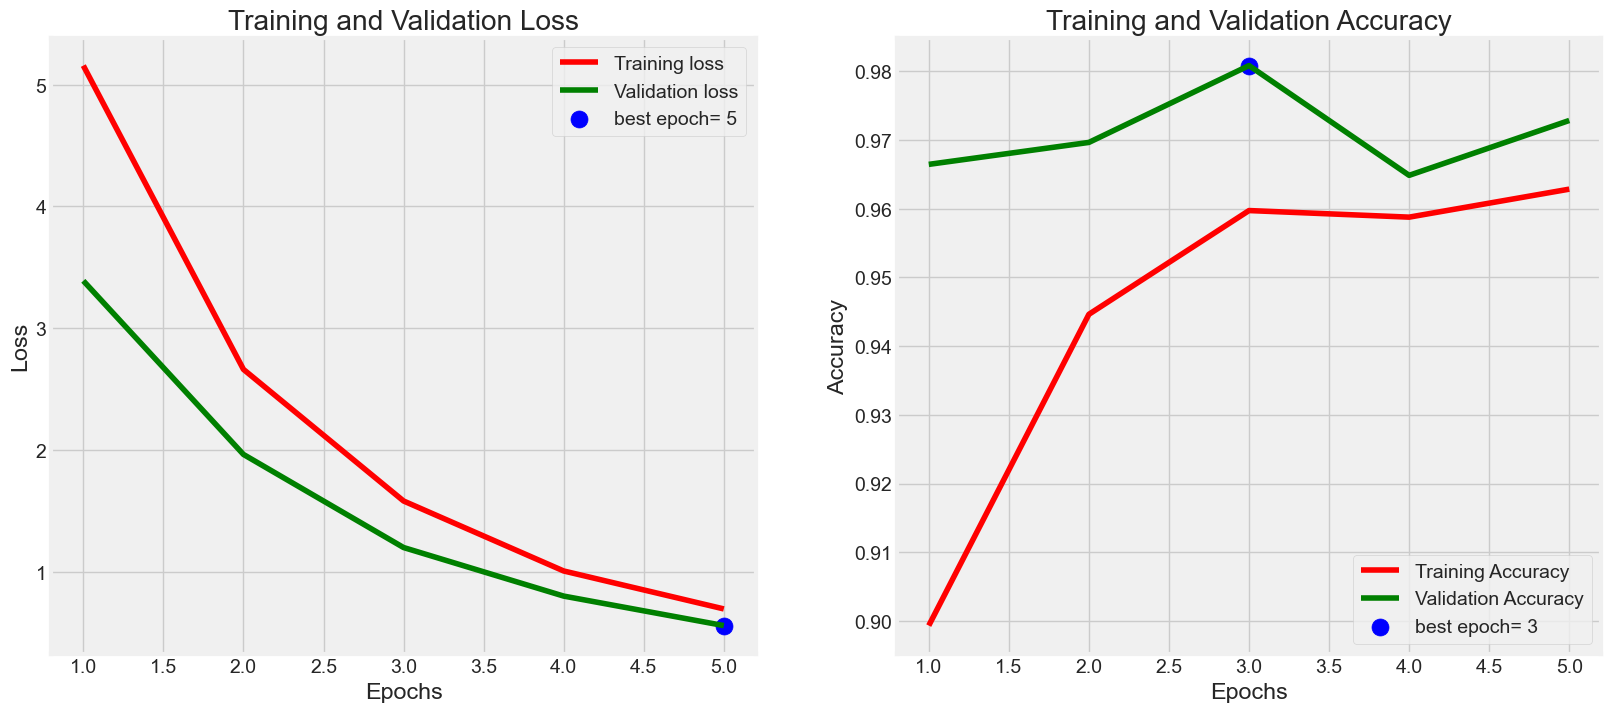

In [10]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout

**Evaluate Model**

In [11]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

11/11 [==============================] - 28s 3s/step - loss: 0.5716 - accuracy: 0.9665
Train Loss:  0.5403050780296326
Train Accuracy:  0.9886363744735718
--------------------
Validation Loss:  0.5509664416313171
Validation Accuracy:  0.9886363744735718
--------------------
Test Loss:  0.5716108679771423
Test Accuracy:  0.9665071964263916


*Get Predictions*

In [12]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

**Confusion Matrix and Classification Report**

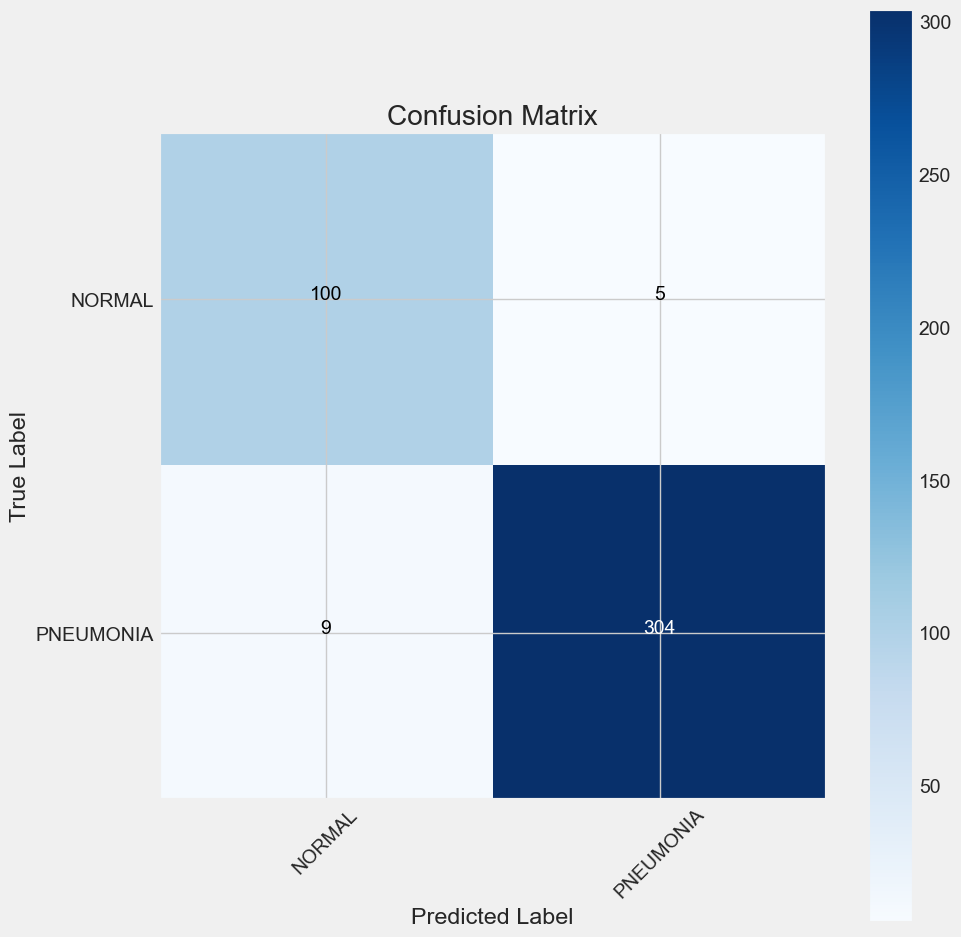

In [13]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [14]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       0.92      0.95      0.93       105
   PNEUMONIA       0.98      0.97      0.98       313

    accuracy                           0.97       418
   macro avg       0.95      0.96      0.96       418
weighted avg       0.97      0.97      0.97       418



**Save the model**

In [15]:
#Save the model
model.save('Pneumonia Detection .h5')

**Prediction using loaded model**

In [16]:
loaded_model = tf.keras.models.load_model('Pneumonia Detection .h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])

In [17]:
image_path = "D:/Mini Project/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg"
image = Image.open(image_path)

#"D:\Mini Project\chest_xray\test\NORMAL\IM-0011-0001.jpeg"
# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Normal', 'Pneumonia']
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 2s 2s/step
Pneumonia


GUI

In [1]:
import tkinter as tk
from tkinter import filedialog
from tkinter import PhotoImage
import numpy as np
from PIL import Image, ImageTk
#import tensorflow as tf
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.optimizers import Adamax

# Load the pre-trained model
loaded_model = tf.keras.models.load_model('Pneumonia Detection .h5', compile=False)
#loaded_model.compile(Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Create the main application window
app = tk.Tk()
app.title("Pneumonia Detection")
app.geometry("800x600")

# Function to browse and load an image
def browse_image():
    global img_path
    img_path = filedialog.askopenfilename()
    if img_path:
        load_and_display_image(img_path)

# Function to load and display an image
def load_and_display_image(file_path):
    global img_label, img, original_img
    original_img = Image.open(file_path)  # Store the original image
    original_img.thumbnail((400, 400))
    img = ImageTk.PhotoImage(original_img)
    img_label.config(image=img)
    img_label.image = img
    result_label.config(text="")  # Clear the prediction label
    predict_button.config(state="normal")

# Function to predict pneumonia
def predict_pneumonia():
    global img_path
    if img_path is None:
        return

    # Save the original image as a temporary file
    original_img.save("temp_image.png")

    # Convert the Tkinter PhotoImage to a PIL Image
    img_pil = original_img.resize((224, 224))
    
    # Display the image and its size for debugging
    #img_pil.show()
    print("Image size:", img_pil.size)

    # Preprocess the image
    img_array = image.img_to_array(img_pil)
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    predictions = loaded_model.predict(img_array)
    class_labels = ['Normal', 'Pneumonia']
    result_label.config(text=f"Prediction: {class_labels[np.argmax(predictions)]}", fg="blue")

# Function to exit the application
def exit_app():
    app.destroy()

# Create widgets
browse_button = tk.Button(app, text="Browse Image", command=browse_image)
predict_button = tk.Button(app, text="Predict", command=predict_pneumonia, state="disabled")
result_label = tk.Label(app, text="", font=("Helvetica", 24))
img_label = tk.Label(app)

# Create an exit button
exit_button = tk.Button(app, text="Exit", command=exit_app)

# Place widgets on the window
browse_button.pack(pady=20)
img_label.pack()
predict_button.pack(pady=20)
result_label.pack()
exit_button.pack(pady=20)

# Initialize img_path
img_path = None

# Start the main loop
app.mainloop()
